# Load data using dataframe.

% pip install neurokit2

conda install conda-forge::neurokit2

In [199]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn import tree


from sklearn.model_selection import cross_val_score

from scipy.signal import find_peaks

# import graphviz


import os

In [185]:

def convert_units(data):
    eda = (data / 2**10) * 3.3 / 0.12
    return eda


In [186]:
# Load data in file Data/Session_3.csv into a pandas dataframe

# Load data from file

datadir = os.path.join('..', 'data')

data = pd.read_csv(os.path.join(datadir, 'session_Test_01.csv'))

# Sampling freq.
fs = 1000



In [187]:

# Display the data
data.head()

,Time,Resp,ECG,EDA,Trigger
0,0.000,524.0,476.0,14.152832,-1.0
1,0.001,524.0,475.0,14.152832,-1.0
2,0.002,524.0,473.0,14.152832,-1.0
3,0.003,523.0,472.0,14.152832,-1.0
4,0.004,524.0,472.0,14.152832,-1.0


In [188]:
# get unique triggers
triggers = data['Trigger'].unique()

# print the unique triggers
print("Unique triggers:", triggers)

Unique triggers: ['-1.0' 'q' 't' 'f']


In [189]:
data['EDA'] = convert_units(data['EDA'])


In [190]:
from scipy.signal import detrend

# remove mean and trend from Resp
data['Resp'] = detrend(data['Resp'])

# Trigger management
Transform p into -1 , and remove excess of 0 and 1

In [191]:
# change value in position i in Trigger column to -1.0 if the value in  sample i-1 was 'p', '0', or '1'



# Create a list of the indexes of the rows that need to be changed
#indexes_to_change = []
#for i in range(1, len(data)):
 #   if data.loc[i-1, 'Trigger'] in ['q', 't', 'f']:
  #      indexes_to_change.append(i)

# Change the values in the Trigger column
#data.loc[indexes_to_change, 'Trigger'] = '-1.0'

# change p in Trigger column to -1.0
data.loc[data['Trigger'] == 'q', 'Trigger'] = '-1.0'


# change t in Trigger column to 1.0
data.loc[data['Trigger'] == 't', 'Trigger'] = '1.0'


# change f in Trigger column to 0.0
data.loc[data['Trigger'] == 'f', 'Trigger'] = '0.0'


# Convert the values in the Trigger column to float
data['Trigger'] = data['Trigger'].astype(float)

# get trigger values above -1
trigger_values = data[data['Trigger'] > -1.0]['Trigger']


print(len(trigger_values))



20


In [192]:
trigger_values

34000      1.0
90000      0.0
144000     1.0
200000     0.0
256000     1.0
312000     0.0
367000     1.0
421000     0.0
481000     1.0
536000     0.0
590000     1.0
647000     0.0
701000     1.0
757000     0.0
817000     1.0
876000     0.0
934000     1.0
989000     0.0
1044000    1.0
1100000    0.0
Name: Trigger, dtype: float64

# Data visualization

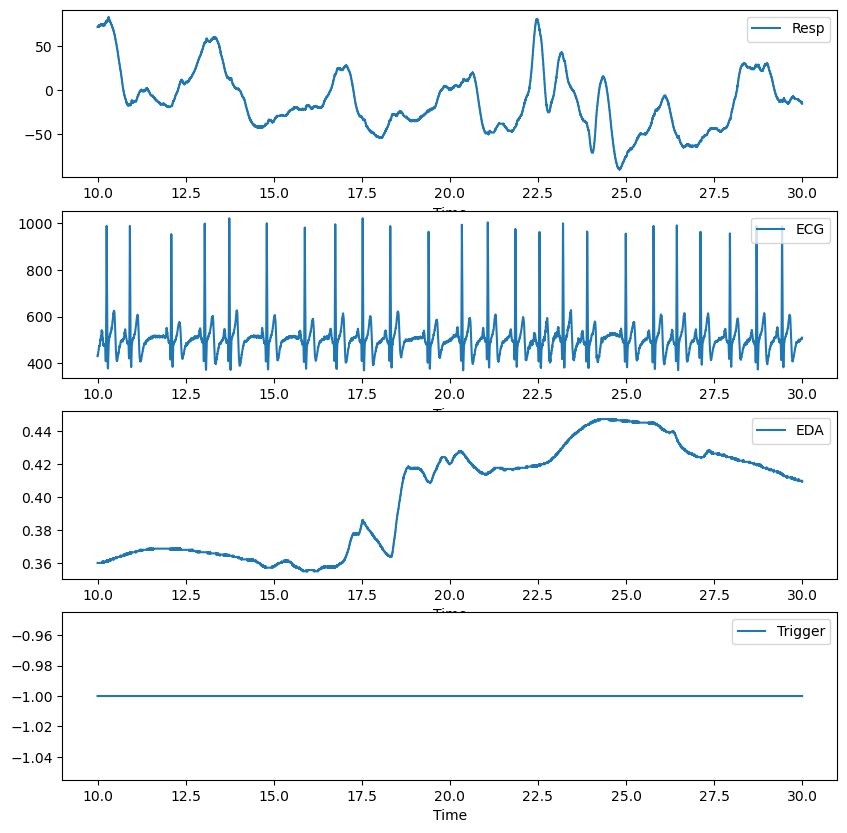

In [193]:
# plot the data, x-axis is the first column, subplots for the second, third and fourth column

offset=10000
wSize=20000

# figure with 3 subplots only show 10 seconds of data
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# plot the data
data.iloc[offset:offset+wSize].plot(x='Time', y='Resp', ax=axs[0])
data.iloc[offset:offset+wSize].plot(x='Time', y='ECG', ax=axs[1])
data.iloc[offset:offset+wSize].plot(x='Time', y='EDA', ax=axs[2])
data.iloc[offset:offset+wSize].plot(x='Time', y='Trigger', ax=axs[3])

# show the plot
plt.show()



# Extract epochs

In [194]:
# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples
ePreSize= 4*fs
ePosSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(data.iloc[indices[i]-ePreSize:indices[i]+ePosSize])

num_epochs = len(epochs)
print(num_epochs)


20


# Resp features.

In [203]:
# compute average of segments
rMean = []
rSD = []
rMax = []
rMin = []
rUnderCurve = []
rResp_rate_variability = []
rBreath_hold_ratio = []

for ep in epochs:
    rMean.append(ep['Resp'][ePreSize:].mean()/ep['Resp'][:ePreSize].mean())
    rSD.append(ep['Resp'][ePreSize:].std()/ep['Resp'][:ePreSize].std())
    rMax.append(ep['Resp'][ePreSize:].max()/ep['Resp'][:ePreSize].max())
    rMin.append(ep['Resp'][ePreSize:].min()/ep['Resp'][:ePreSize].min())
    rUnderCurve.append(np.trapz(ep['Resp'][ePreSize:])/np.trapz(ep['Resp'][:ePreSize]))
    
    #respiratory rate variability
    peaks, _ = find_peaks(ep['Resp'][ePreSize:], distance=fs//2)
    if len(peaks) > 1:
        intervals = np.diff(peaks) / fs  # Intervaly mezi náddechy
        rrv = np.std(intervals) / np.mean(intervals)  # Koeficient variace
        rResp_rate_variability.append(rrv)
    else:
        rResp_rate_variability.append(0)
        
    # Breath hold detection
    post_resp = ep['Resp'][ePreSize:]
    # Najít oblasti s minimální aktivitou
    low_activity = np.abs(post_resp) < np.std(post_resp) * 0.3
    hold_ratio = np.sum(low_activity) / len(post_resp)
    rBreath_hold_ratio.append(hold_ratio)


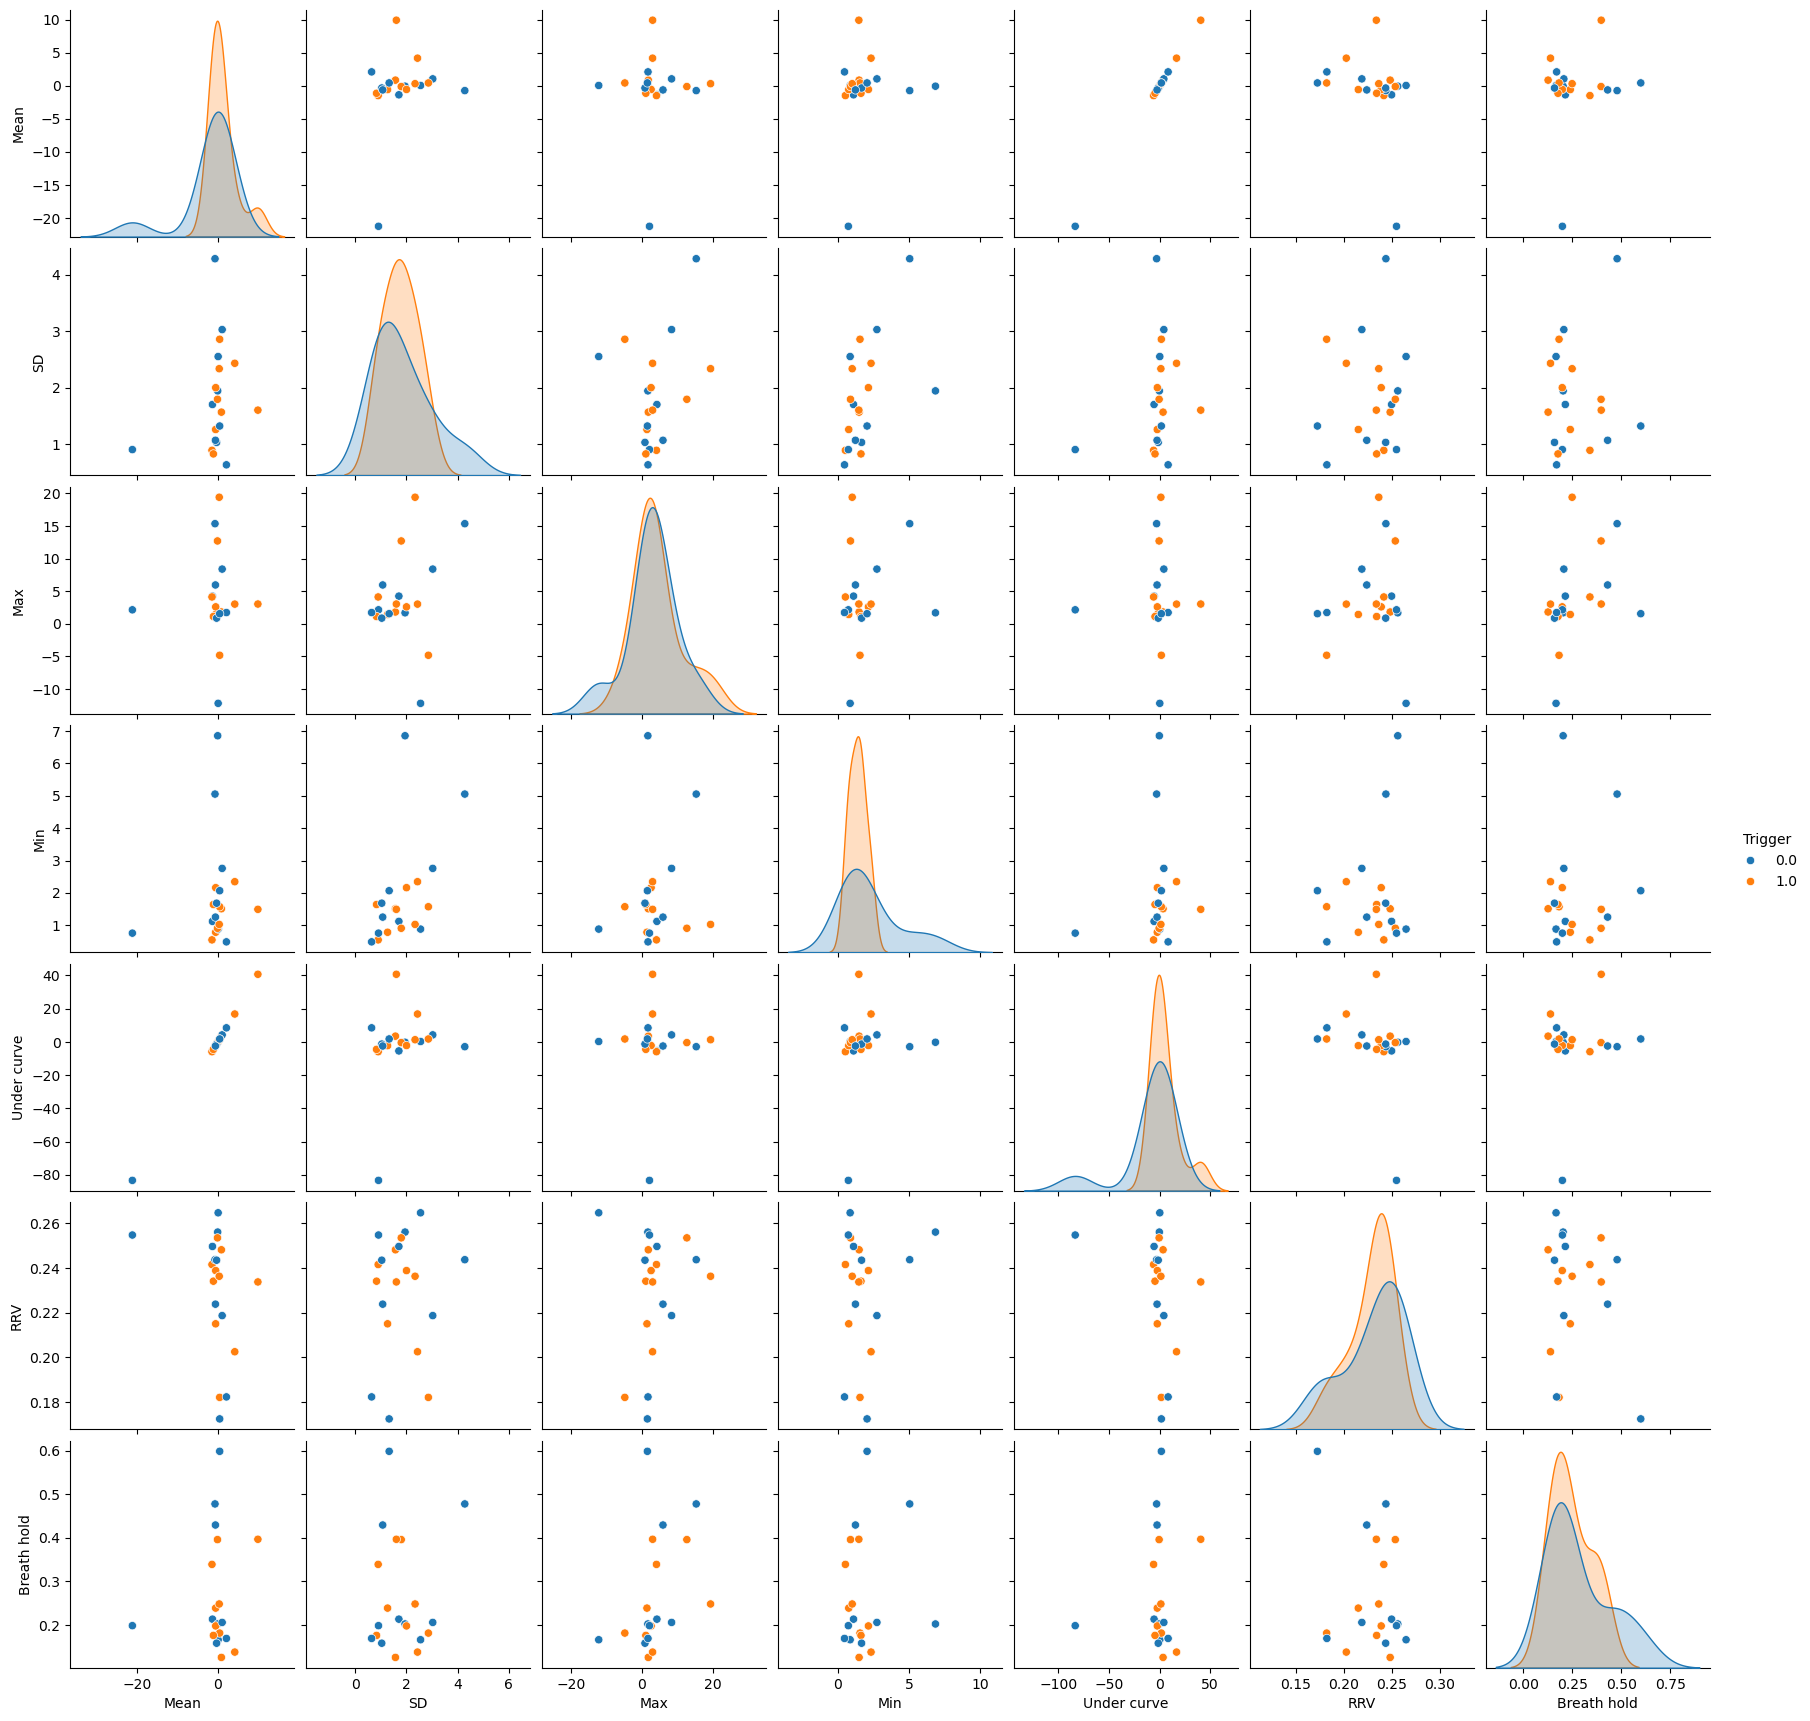

In [204]:
# show feature  grouped by trigger_values 0 and 1 using seaborn
df = pd.DataFrame({'Mean': rMean, 'SD': rSD, 'Max': rMax, 'Min': rMin, 'Trigger': trigger_values, 'Under curve': rUnderCurve, 'RRV':rResp_rate_variability, 'Breath hold': rBreath_hold_ratio})

sns.pairplot(df, hue='Trigger')
plt.show()

# EDA features.

In [ ]:

# Load data from file
eda = data['EDA']

# compute the EDA features
eda_features = nk.eda_process(eda, sampling_rate=1000)


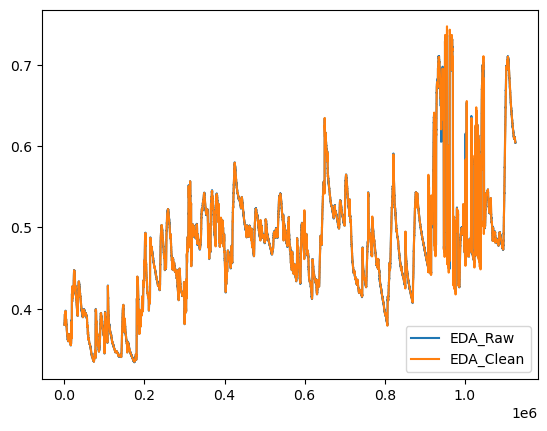

In [ ]:
eda_features[0]['EDA_Raw'].plot()
eda_features[0]['EDA_Clean'].plot()
plt.legend(loc="lower right")
plt.show()


In [ ]:


# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples

preSize= 4*fs
posSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(eda_features[0].iloc[indices[i]-preSize:indices[i]+posSize])

num_epochs = len(epochs)
print(num_epochs)



20


In [ ]:
# compute average of segments
edaMean = []
edaSD = []
edaMax = []
edaMin = []
eUnderCurve = []

for ep in epochs:
    edaMean.append(ep['EDA_Clean'][preSize:].mean()/ep['EDA_Clean'][:preSize].mean())
    edaSD.append(ep['EDA_Clean'][preSize:].std()/ep['EDA_Clean'][:preSize].std())
    edaMax.append(ep['EDA_Clean'][preSize:].max()/ep['EDA_Clean'][:preSize].max())
    edaMin.append(ep['EDA_Clean'][preSize:].min()/ep['EDA_Clean'][:preSize].min())
    eUnderCurve.append(np.trapz(ep['EDA_Clean'][ePreSize:])/np.trapz(ep['EDA_Clean'][:preSize]))

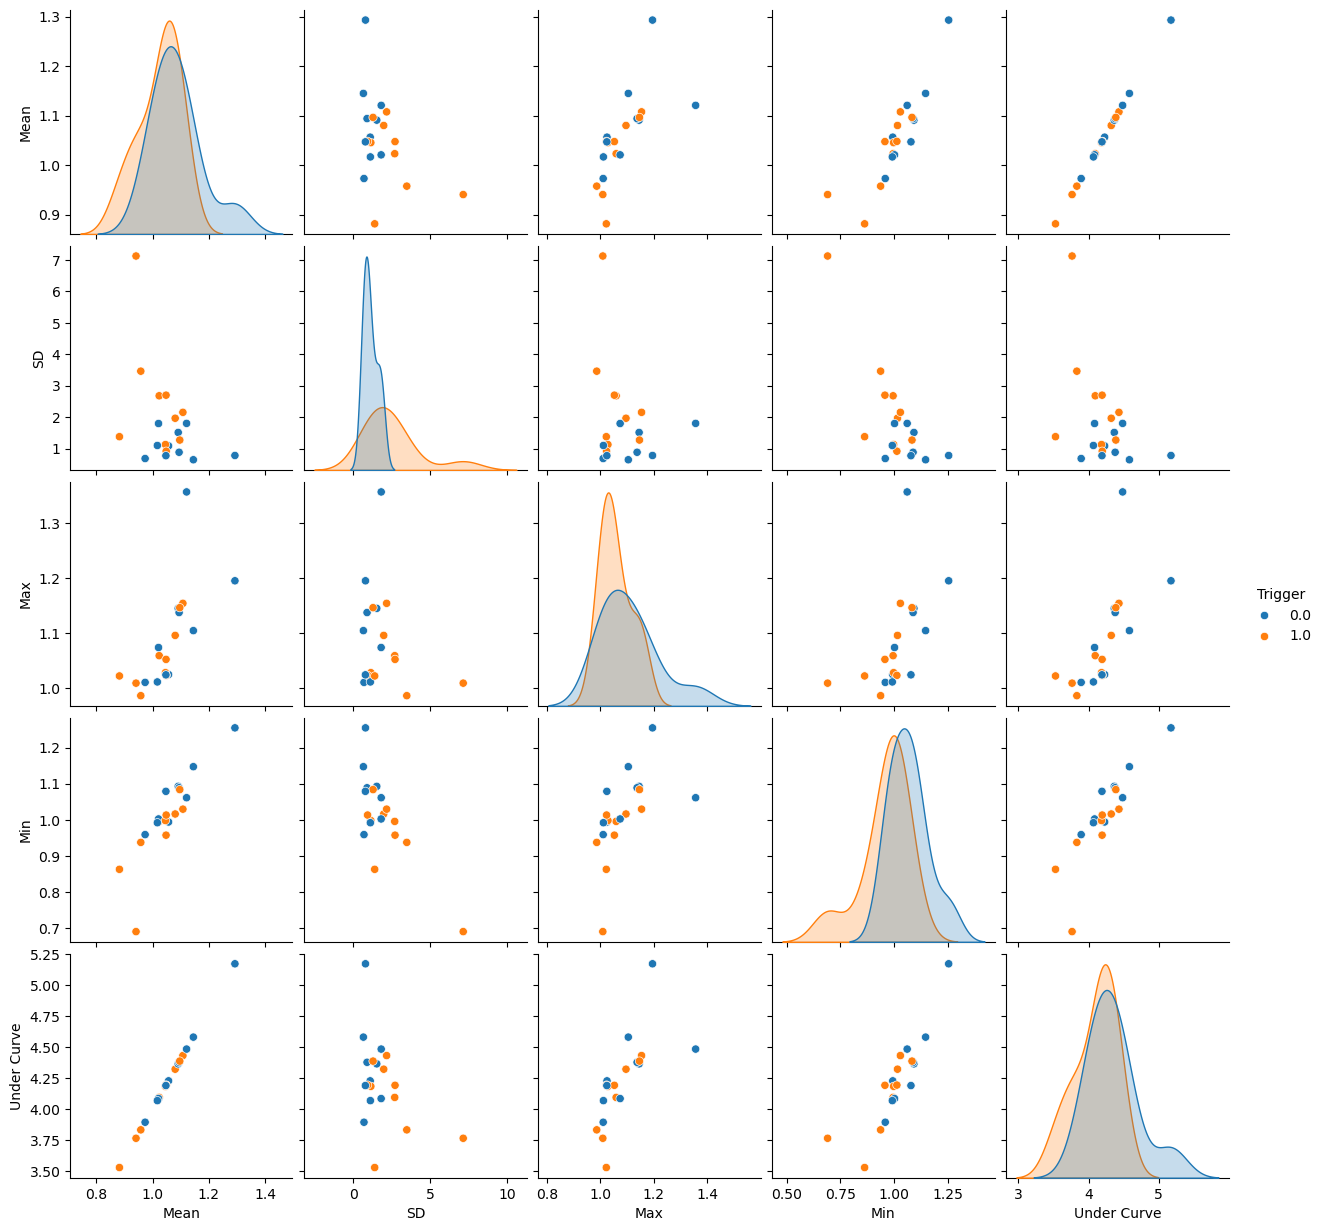

In [ ]:
# show feature  grouped by trigger_values 0 and 1 using seaborn
df = pd.DataFrame({'Mean': edaMean, 'SD': edaSD, 'Max': edaMax, 'Min': edaMin, 'Trigger': trigger_values, 'Under Curve': eUnderCurve})

sns.pairplot(df, hue='Trigger')
plt.show()

# ECG

In [ ]:
ecg_cleaned = nk.ecg_clean(data['ECG'], sampling_rate=1000)

instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
_, waves_peak = nk.ecg_delineate(data['ECG'], rpeaks, sampling_rate=1000, method="peak")

rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


# Prepare output
signals = pd.DataFrame({"ECG_Raw": data['ECG'],
                        "ECG_Clean": ecg_cleaned,
                        "ECG_Rate": rate,
                        "ECG_Quality": quality})


signals = pd.concat([signals, instant_peaks], axis=1)

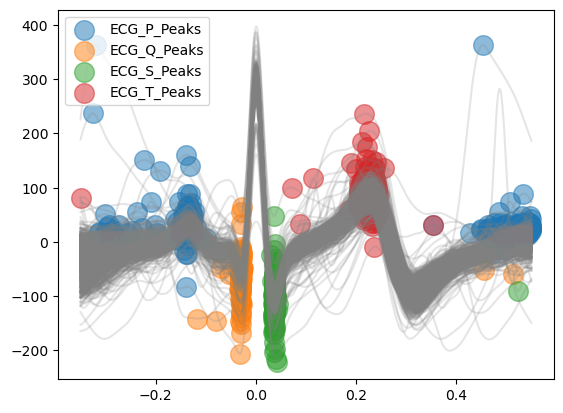

In [ ]:
signal_dwt, waves_dwt = nk.ecg_delineate(signals,
                                        rpeaks,
                                        sampling_rate=1000,
                                        method="dwt",
                                        show=True,
                                        show_type='peaks')

In [ ]:
epochs=[]

# Process the data for event-related analysis
df, info = nk.bio_process(ecg=signals['ECG_Clean'], sampling_rate=1000)


events = nk.events_find(data["Trigger"], threshold=-1.0, event_conditions=trigger_values.values, threshold_keep='above')

epochs = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=-1.0, epochs_end=7.0)

# Analyze
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=1000)

# Get a dataframe with all the results

analyze_epochs

/opt/anaconda3/envs/BESTcourse/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/opt/anaconda3/envs/BESTcourse/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/opt/anaconda3/envs/BESTcourse/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/opt/anaconda3/envs/BESTcourse/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Wi

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Quality_Mean
1,1,1.0,34000,88.535781,-0.008636,-26.035781,-16.346842,6.332680,0.001125,4.245656,-5.694496,-5.152272,0.482067,0.956051
2,2,0.0,90000,56.481992,26.967243,-3.243305,10.140173,7.325787,1.534317,4.414677,-1.566361,13.878960,0.053846,0.932682
3,3,1.0,144000,92.531691,-0.024935,-36.246512,-22.189605,8.858016,0.001125,5.871859,-2.049400,-14.431111,0.275468,0.951201
4,4,0.0,200000,56.960354,13.215085,-1.558692,8.179995,4.494429,1.418302,6.046881,4.186933,5.534554,0.543337,0.936161
5,5,1.0,256000,62.152637,11.738988,-2.746697,3.375937,4.333825,3.812602,6.578947,7.636694,-6.776069,0.792817,0.924676
6,6,0.0,312000,65.098823,14.688411,-9.180836,-3.301142,6.668199,0.451181,5.490811,-4.407689,5.843230,0.314266,0.896131
7,7,1.0,367000,61.319411,23.187631,-6.524891,10.391286,9.631535,5.624828,2.511439,0.909865,3.071287,0.325789,0.937102
8,8,0.0,421000,62.619098,14.303979,-9.095458,0.883389,6.886903,2.234404,5.082760,5.690953,-5.541570,0.192670,0.961022
9,9,1.0,481000,61.733454,7.073885,-5.501027,-2.233569,3.100754,2.634454,3.701588,0.208913,-1.211461,0.140966,0.964068
10,10,0.0,536000,65.477798,10.279778,-1.918476,2.324410,2.732754,4.952744,2.350419,-0.165914,1.620803,0.091874,0.946075


In [ ]:
test = epochs['1']['ECG_Clean']
df, _ = nk.bio_process(test, sampling_rate=1000)
df

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,0.591388,-24.688020,72.250468,0.922623,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-3.648759,-28.483583,72.250468,0.922623,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-7.878896,-32.270136,72.250468,0.922623,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-12.089025,-36.038718,72.250468,0.922623,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-16.259145,-39.780457,72.250468,0.922623,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,4.735107,-9.236387,64.034152,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7996,5.156803,-8.828733,64.034152,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7997,5.568492,-8.422298,64.034152,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7998,5.972675,-8.016724,64.034152,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


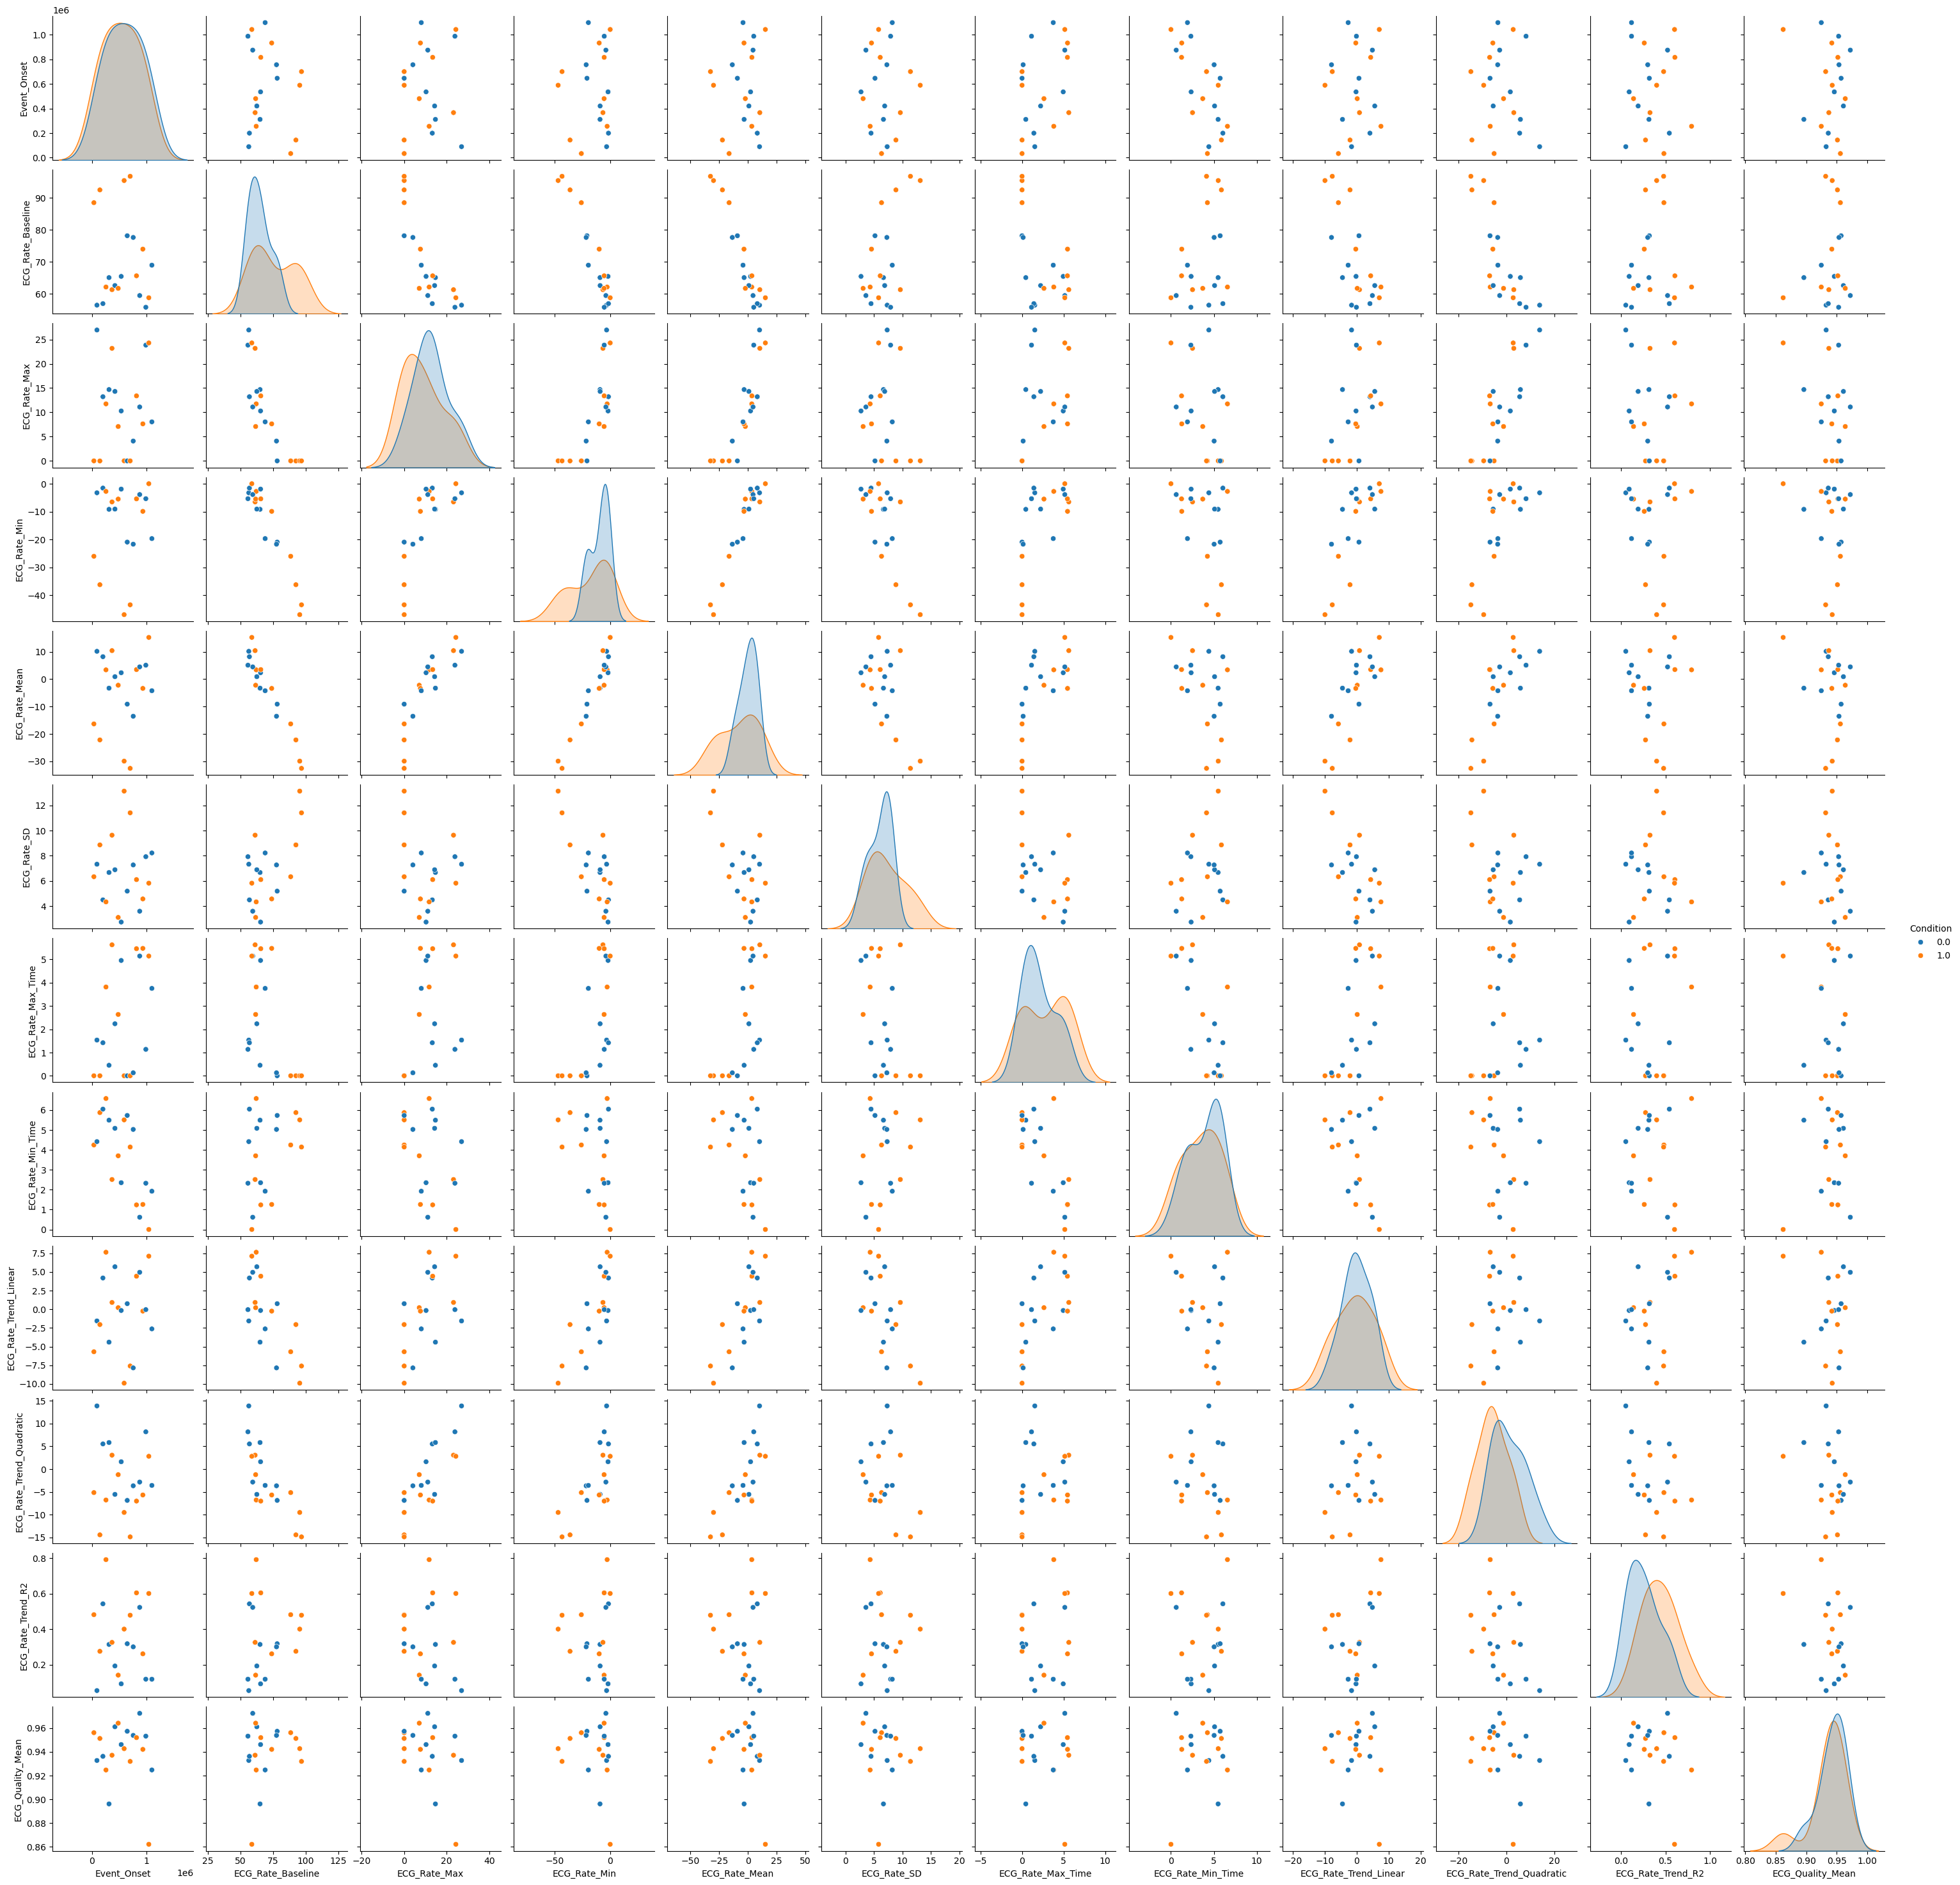

In [ ]:
# show feature  grouped by trigger_values 0 and 1 using seaborn


sns.pairplot(analyze_epochs, hue='Condition')
plt.show()

In [ ]:
analyze_epochs.columns

Index(['Label', 'Condition', 'Event_Onset', 'ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean'],
      dtype='object')

<Axes: xlabel='Condition', ylabel='ECG_Rate_Max'>

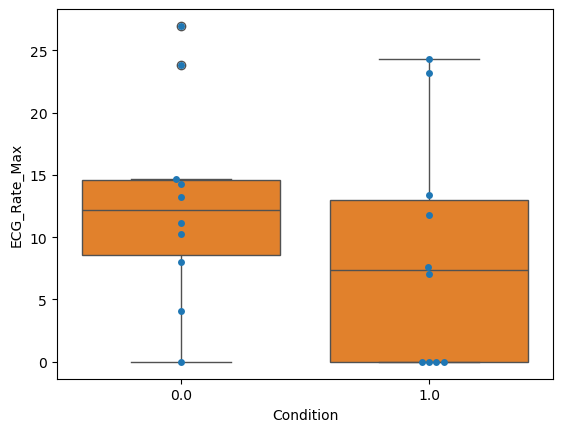

In [ ]:
# show feature ECG_Rate_Baseline grouped by condition 0 and 1 using seaborn with points
#sns.swarmplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)
#sns.boxplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)



sns.swarmplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)
sns.boxplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)




# Classifier - decision tree and graph design

# Create array X with the features and array y with the target variable
X = analyze_epochs[['ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean']]

# Add coumns to X with the EDA features
X['EDA_Mean'] = edaMean
X['EDA_SD'] = edaSD
X['EDA_Max'] = edaMax
X['EDA_Min'] = edaMin

# Add column to X with the Resp features
X['Resp_Mean'] = rMean
X['Resp_SD'] = rSD
X['Resp_Max'] = rMax
X['Resp_Min'] = rMin


y = analyze_epochs['Condition']


model = DecisionTreeClassifier(max_depth=7, random_state=0)

model.fit(X, y)

scores = cross_val_score(estimator=model,
                         X=X,
                        y=y,
                        cv=3,
                        scoring='accuracy')


print(scores, scores.mean())
import pickle

with open('x.pkl','wb') as f:
    pickle.dump(X,f)


with open('y.pkl','wb') as f:
    pickle.dump(y,f)


# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)



# Use svm as classifier
from sklearn.svm import SVC

svmmodel = SVC()

scores = cross_val_score(estimator=svmmodel,
                         X=X,
                        y=y,
                        cv=3,
                        scoring='accuracy')

print(scores, scores.mean())

model.fit(X, y)

In [ ]:
model.predict(X)

NameError: name 'model' is not defined


dot_data = tree.export_graphviz(model,
                  feature_names=X.columns,
                  class_names=['0', '1'],
                  filled=True,
                  rounded=True,
                  special_characters=True,
                out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph
